# Anomaly Detection using Isolation Forest

    Isolation forest is basically a tree based model which does not takes time into consideration like other models like 
    ARIMA or FB Prophet. You can say its a non time series model.
    In order to feed context to the isolation forest on the time element we do the feature engineering. 
    When data is very high dimensional then go with the Isolation forest because it is easy here to interpret 

### 3 types of anomaly in data

1. `Global or point anomaly` : Easy to identify and out of normal distribution
2. `Contextual Anomaly` : Difficult to identify. if its value deviates from the rest w.r.t some context
3. `Corrective anomaly` : 

In [53]:
import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import plotly.express as px

from sklearn.ensemble import IsolationForest

mat.rcParams['figure.figsize'] = (10,8)
mat.rcParams['axes.grid'] = False

In [54]:
df = pd.read_csv('nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [56]:
df['timestamp'] = pd.to_datetime(df['timestamp']) # CONVERTING INTO DATE TIME TYPE

### resampling into Hour level

In [57]:
df = df.set_index('timestamp').resample('H').mean().reset_index()

In [58]:
df

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [59]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title="NYC Taxi Demand")

fig.update_xaxes(
        rangeslider_visible=True
)
fig.show()

# Isolation forest does not understands the date time context so we need to manually feed into the model !!

In [60]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = pd.Categorical(df['timestamp'].dt.strftime('%A'),
                               categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                              )

In [61]:
df

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday
...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday
5156,2015-01-31 20:00:00,24138.0,20,Saturday
5157,2015-01-31 21:00:00,24194.5,21,Saturday
5158,2015-01-31 22:00:00,26515.0,22,Saturday


### Daily Seasonality is there..

     So basically we need to do it manually bcoz if there is a seasonality then we need to put it as an feature to the model
     so that the isolation forest can understand the context ..in order to identify the contextual outliers.

<AxesSubplot:xlabel='hour'>

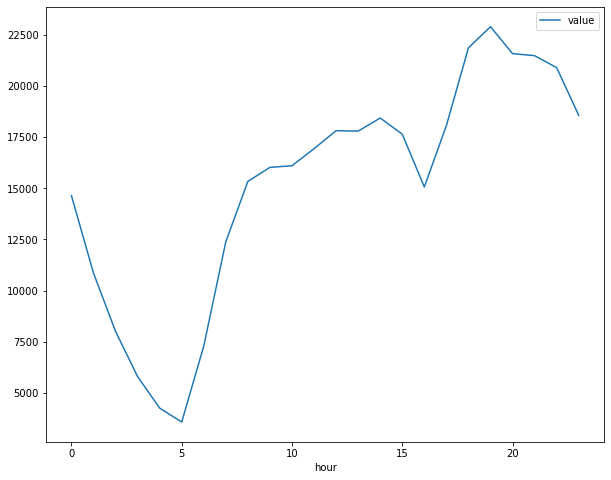

In [62]:
df[['value', 'hour']].groupby('hour').mean().plot()

### Weekday seasonality is also there

<AxesSubplot:xlabel='weekday'>

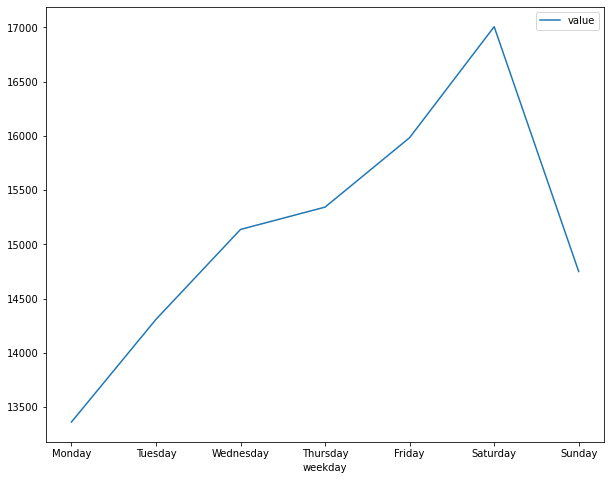

In [63]:
df[['value', 'weekday']].groupby('weekday').mean().plot()

<AxesSubplot:xlabel='hour'>

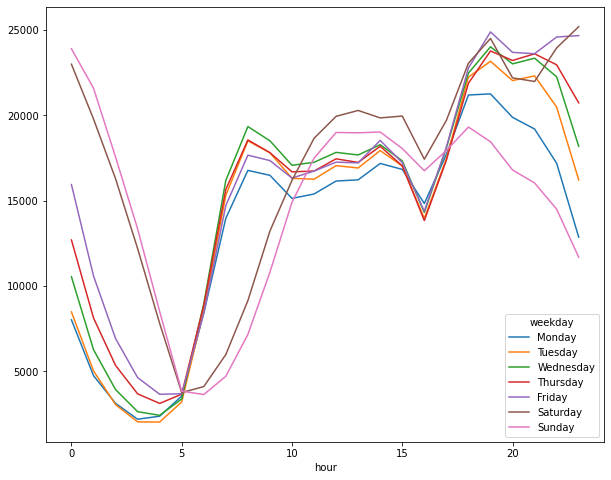

In [64]:
df.groupby(['hour', 'weekday']).mean()['value'].unstack().plot() # unstack ..just to plot week days differently

### it will show avg on a particular hour on a particular weekday

In [65]:
df.join(df.groupby(['hour', 'weekday'])['value'].mean(), on=['hour', 'weekday'], rsuffix='_avg')

,timestamp,value,hour,weekday,value_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613


In [27]:
df_final = df.join(df.groupby(['hour', 'weekday'])['value'].mean(), on=['hour', 'weekday'], rsuffix='_avg')
df_final

,timestamp,value,hour,weekday,value_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613


### Anomalous Points

`NYC Marathon - 2014-11-02
Thanks Giving - 2014-11-27
Christmas - 2014-12-25
New Years - 2015-01-01
Snow Blizzard - 2015-01-26 and 2015-01-27
`

In [30]:
df_final.set_index('timestamp').loc['2014-11-02']

,value,hour,weekday,value_avg
timestamp,,,,
2014-11-02 00:00:00,24109.5,0,Sunday,23898.733333
2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333
2014-11-02 02:00:00,12754.5,2,Sunday,17555.266667
2014-11-02 03:00:00,8955.5,3,Sunday,13350.550000
2014-11-02 04:00:00,5453.5,4,Sunday,8506.500000
2014-11-02 05:00:00,5174.0,5,Sunday,3837.450000
2014-11-02 06:00:00,4920.0,6,Sunday,3643.983333
2014-11-02 07:00:00,5592.0,7,Sunday,4711.300000
2014-11-02 08:00:00,7525.5,8,Sunday,7159.516667


In [31]:
df_final.set_index('timestamp').loc['2015-01-26':'2015-01-27']

,value,hour,weekday,value_avg
timestamp,,,,
2015-01-26 00:00:00,5907.0,0,Monday,8020.283333
2015-01-26 01:00:00,3649.5,1,Monday,4749.750000
2015-01-26 02:00:00,2310.0,2,Monday,3125.800000
2015-01-26 03:00:00,1949.5,3,Monday,2195.133333
2015-01-26 04:00:00,2165.5,4,Monday,2373.166667
2015-01-26 05:00:00,3723.0,5,Monday,3550.800000
2015-01-26 06:00:00,9146.0,6,Monday,8414.566667
2015-01-26 07:00:00,15835.5,7,Monday,13968.766667
2015-01-26 08:00:00,18804.5,8,Monday,16774.483333


In [33]:
df_final['day'] = df.timestamp.dt.weekday

In [34]:
df_final

,timestamp,value,hour,weekday,value_avg,day
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1
...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5


In [35]:
data = df_final[['value', 'hour', 'day']]

# Isolation forest :
`Isolation forest is basically the unsupervised machine learning algorithm that works basically on the principal of 
isolating anomalies instead of profilling the normal data. So it profiles the abnormal data...thats y we dont have label in this case`

In [36]:
model = IsolationForest(contamination=0.005, max_features=3, max_samples=0.8, n_estimators=200) # contamination means it will show me only .5 % of the top anomaly
model.fit(data)

IsolationForest(contamination=0.005, max_features=3, max_samples=0.8,
                n_estimators=200)

# the output of the model will be basically -1 or +1 so -1 is the anomalous point

In [37]:
df_final['outliers'] = pd.Series(model.predict(data)).apply(lambda x : 'yes' if (x==-1) else 'no')
df_final

,timestamp,value,hour,weekday,value_avg,day,outliers
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1,no
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1,no
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1,no
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1,no
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1,no
...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5,no
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5,no
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5,no
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5,no


In [38]:
df_final.query('outliers=="yes"')

,timestamp,value,hour,weekday,value_avg,day,outliers
1488,2014-09-01 00:00:00,13763.0,0,Monday,8020.283333,0,yes
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes
2640,2014-10-19 00:00:00,27146.5,0,Sunday,23898.733333,6,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes
4271,2014-12-25 23:00:00,7977.5,23,Thursday,20732.241935,3,yes
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes
4419,2015-01-01 03:00:00,22067.0,3,Thursday,3683.177419,3,yes
4511,2015-01-04 23:00:00,8402.0,23,Sunday,11686.450000,6,yes


In [39]:
fig = px.scatter(df_final, x='timestamp', y='value', color='outliers', hover_data=['weekday', 'hour', 'value_avg'], title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True
)
fig.show()

### Where we can draw a boundary so that we can control

In [40]:
score = model.decision_function(data)

In [41]:
score

array([0.10436401, 0.15005263, 0.17407507, ..., 0.14749556, 0.10894781,
       0.09087445])

(array([  1.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,
          2.,   3.,   3.,   0.,   4.,   2.,   5.,   2.,   5.,   7.,  14.,
         14.,  14.,  22.,  23.,  29.,  49.,  57.,  76.,  77.,  97., 115.,
        121., 194., 208., 227., 296., 357., 393., 379., 411., 360., 357.,
        343., 293., 222., 188., 131.,  54.]),
 array([-0.12284727, -0.11623908, -0.10963089, -0.1030227 , -0.09641451,
        -0.08980632, -0.08319813, -0.07658994, -0.06998175, -0.06337356,
        -0.05676537, -0.05015718, -0.04354899, -0.0369408 , -0.03033261,
        -0.02372441, -0.01711622, -0.01050803, -0.00389984,  0.00270835,
         0.00931654,  0.01592473,  0.02253292,  0.02914111,  0.0357493 ,
         0.04235749,  0.04896568,  0.05557387,  0.06218206,  0.06879025,
         0.07539844,  0.08200663,  0.08861483,  0.09522302,  0.10183121,
         0.1084394 ,  0.11504759,  0.12165578,  0.12826397,  0.13487216,
         0.14148035,  0.14808854,  0.15469673,  0.16130492,  0.16791311,
 

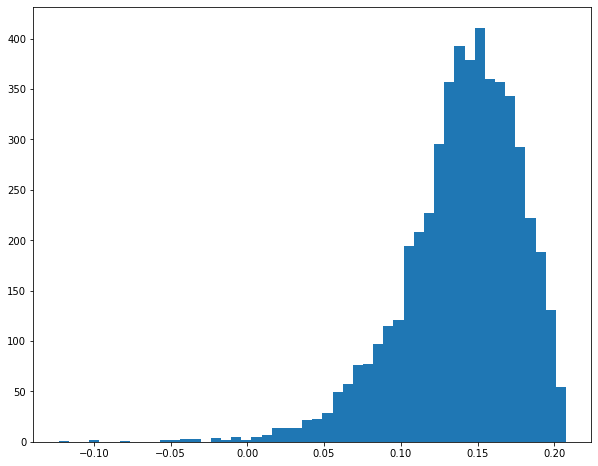

In [43]:
plt.hist(score, bins=50)

In [44]:
df_final['scores'] = score

In [45]:
df_final

,timestamp,value,hour,weekday,value_avg,day,outliers,scores
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1,no,0.104364
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1,no,0.150053
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1,no,0.174075
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1,no,0.172870
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1,no,0.177110
...,...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5,no,0.026274
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5,no,0.148199
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5,no,0.147496
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5,no,0.108948


In [48]:
df_final.query('scores<-0.02')

,timestamp,value,hour,weekday,value_avg,day,outliers,scores
1488,2014-09-01 00:00:00,13763.0,0,Monday,8020.283333,0,yes,-0.022851
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes,-0.056519
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes,-0.122847
4271,2014-12-25 23:00:00,7977.5,23,Thursday,20732.241935,3,yes,-0.031737
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes,-0.042450
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes,-0.099339
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes,-0.041029
4511,2015-01-04 23:00:00,8402.0,23,Sunday,11686.450000,6,yes,-0.038595
5034,2015-01-26 18:00:00,5703.5,18,Monday,21190.150000,0,yes,-0.021290
5035,2015-01-26 19:00:00,4565.5,19,Monday,21255.900000,0,yes,-0.035517
